# Libraries

In [1]:
!pip install optuna --quiet

     |████████████████████████████████| 348 kB 5.4 MB/s 
     |████████████████████████████████| 81 kB 5.9 MB/s 
     |████████████████████████████████| 209 kB 42.8 MB/s 
     |████████████████████████████████| 78 kB 3.4 MB/s 
     |████████████████████████████████| 50 kB 4.3 MB/s 
     |████████████████████████████████| 112 kB 45.7 MB/s 
     |████████████████████████████████| 147 kB 48.2 MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import (
    LabelEncoder, 
    OrdinalEncoder, 
    OneHotEncoder, 
    StandardScaler, 
    MinMaxScaler,
)
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import tree
from sklearn import ensemble
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction import DictVectorizer
import optuna
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

In [3]:
df = pd.read_csv("age_of_mariage.csv")
df.sample(n=10)

,id,gender,height,religion,caste,mother_tongue,profession,location,country,age_of_marriage
239,240,male,"5'9""",Hindu,Viswabrahmin,Telugu,Software Professional,Hyderabad,India,29.0
1287,1288,male,"5'6""",Hindu,Brahmin,Marathi,Not working,Clemson- SC,USA,33.0
1865,1866,male,"5'6""",Sikh,Kshatriya,Punjabi,Designer (Others),Amritsar,India,31.0
1221,1222,NaN,NaN,NaN,others,Kannada,NaN,NaN,India,24.0
2482,2483,female,"5'1""",Hindu,Baishnab,Bengali,Not working,Kolkata,India,28.0
2306,2307,male,"5'5""",Hindu,Baishnab,Bengali,Not Specified,Bengaluru / Bangalore,India,27.0
640,641,male,"5'11""",Hindu,Valmiki,Hindi,Civil Engineer,Indore,India,28.0
1614,1615,female,"5'2""",Hindu,Arya Vysya,Telugu,Finance Professional,Bengaluru / Bangalore,India,26.0
2150,2151,male,"5'9""",Hindu,Brahmin,Bengali,Software Professional,Kolkata,India,32.0
883,884,male,"5'9""",Hindu,Scheduled Caste (SC),Telugu,Doctor / Healthcare Professional,Anantapur,India,35.0


In [4]:
df.shape

(2567, 10)

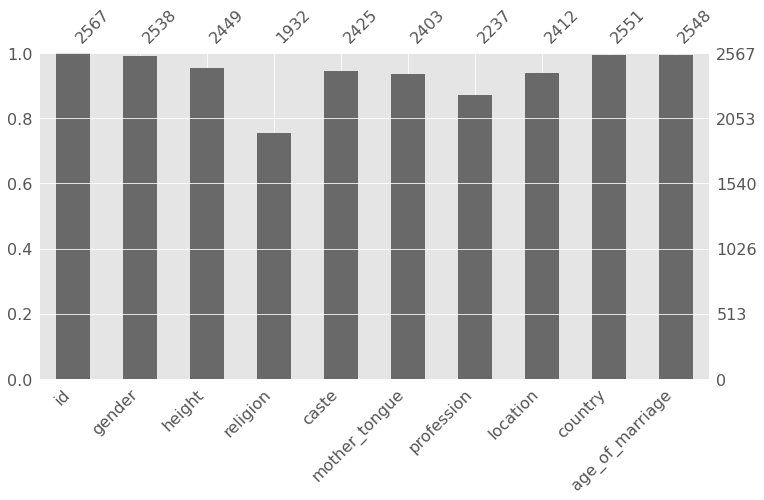

In [5]:
msno.bar(df, figsize=(12,6))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2567 entries, 0 to 2566
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2567 non-null   int64  
 1   gender           2538 non-null   object 
 2   height           2449 non-null   object 
 3   religion         1932 non-null   object 
 4   caste            2425 non-null   object 
 5   mother_tongue    2403 non-null   object 
 6   profession       2237 non-null   object 
 7   location         2412 non-null   object 
 8   country          2551 non-null   object 
 9   age_of_marriage  2548 non-null   float64
dtypes: float64(1), int64(1), object(8)
memory usage: 200.7+ KB


In [7]:
df.astype('object').describe().T

,count,unique,top,freq
id,2567,2567,1,1
gender,2538,2,male,1338
height,2449,28,"5'3""",229
religion,1932,5,Hindu,1576
caste,2425,42,others,493
mother_tongue,2403,27,Hindi,508
profession,2237,86,Not Specified,264
location,2412,536,Mumbai,213
country,2551,29,India,2246
age_of_marriage,2548.0,17.0,30.0,415.0


In [8]:
df.duplicated().sum()

0

In [9]:
df.isna().sum().mul(100).div(len(df))

id                  0.000000
gender              1.129723
height              4.596806
religion           24.737047
caste               5.531749
mother_tongue       6.388781
profession         12.855473
location            6.038177
country             0.623296
age_of_marriage     0.740164
dtype: float64

In [10]:
df['height'][~df['height'].isna()] = (
    df['height'][~df['height'].isna()].str.replace('"', "")
    .str.split("'").apply(
        lambda x: int(x[0])*30.48 + int(x[1])*2.54
    ).astype(float)
)

df['height'] = pd.to_numeric(df.height, errors='coerce')

In [11]:
df.head()

,id,gender,height,religion,caste,mother_tongue,profession,location,country,age_of_marriage
0,1,female,162.56,NaN,others,Telugu,NaN,London,United Kingdom,21.0
1,2,male,170.18,Jain,Shwetamber,Gujarati,Doctor / Healthcare Professional,Fairfax- VA,USA,32.0
2,3,male,170.18,Hindu,Brahmin,Hindi,Entrepreneurs / Business,Begusarai,India,32.0
3,4,female,152.40,Hindu,Thakur,Hindi,Architect,Mumbai,India,30.0
4,5,male,165.10,Christian,Born Again,Malayalam,Sales Professional / Marketing,Sulthan Bathery,India,30.0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2567 entries, 0 to 2566
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2567 non-null   int64  
 1   gender           2538 non-null   object 
 2   height           2449 non-null   float64
 3   religion         1932 non-null   object 
 4   caste            2425 non-null   object 
 5   mother_tongue    2403 non-null   object 
 6   profession       2237 non-null   object 
 7   location         2412 non-null   object 
 8   country          2551 non-null   object 
 9   age_of_marriage  2548 non-null   float64
dtypes: float64(2), int64(1), object(7)
memory usage: 200.7+ KB


In [13]:
df.isna().sum()

id                   0
gender              29
height             118
religion           635
caste              142
mother_tongue      164
profession         330
location           155
country             16
age_of_marriage     19
dtype: int64

In [14]:
df[['height', 'age_of_marriage']].describe().T

,count,mean,std,min,25%,50%,75%,max
height,2449.0,164.352209,11.231685,134.62,157.48,165.1,172.72,213.36
age_of_marriage,2548.0,29.648352,2.802414,20.00,28.00,30.0,32.00,36.00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d42735310>,
      dtype=object)

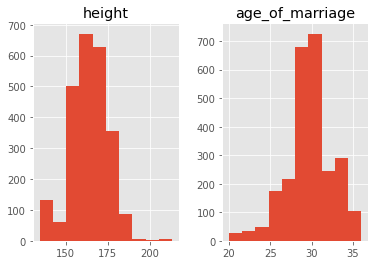

In [15]:
df[['height', 'age_of_marriage']].hist()

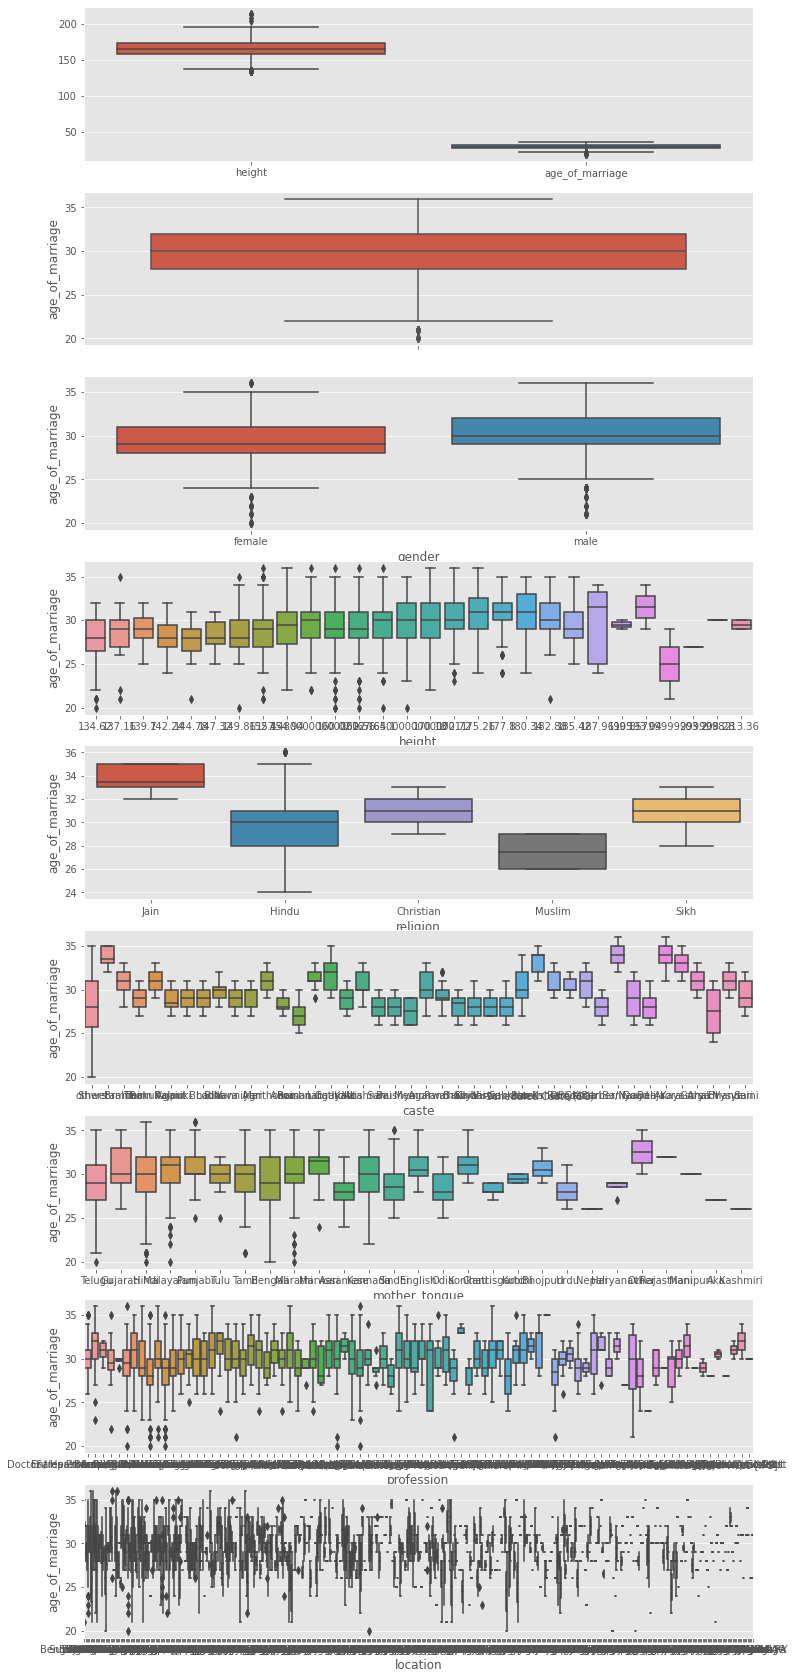

In [16]:
fig, axes = plt.subplots(nrows=9,ncols=1)
fig.set_size_inches(12, 30)
sns.boxplot(data=df.drop(columns=['id']),orient="v",ax=axes[0])
sns.boxplot(data=df,y="age_of_marriage",orient="v",ax=axes[1])
sns.boxplot(data=df,y="age_of_marriage",x="gender",orient="v",ax=axes[2])
sns.boxplot(data=df,y="age_of_marriage",x="height",orient="v",ax=axes[3])
sns.boxplot(data=df,y="age_of_marriage",x="religion",orient="v",ax=axes[4])
sns.boxplot(data=df,y="age_of_marriage",x="caste",orient="v",ax=axes[5])
sns.boxplot(data=df,y="age_of_marriage",x="mother_tongue",orient="v",ax=axes[6])
sns.boxplot(data=df,y="age_of_marriage",x="profession",orient="v",ax=axes[7])
sns.boxplot(data=df,y="age_of_marriage",x="location",orient="v",ax=axes[8])
plt.show();

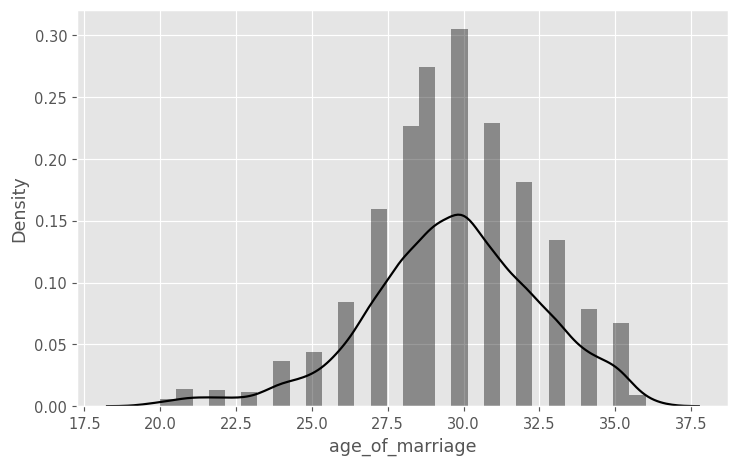

In [17]:
plt.figure(figsize=(8, 5), dpi=105)
sns.distplot(df['age_of_marriage'], color='k', bins=30, hist_kws={'alpha': 0.4});

In [18]:
data, target =(
    df.drop(columns=['id', 'age_of_marriage']), df['age_of_marriage'].
    fillna(df.age_of_marriage.median())
) 

In [19]:
def twk(data=data, target=target, encoder=False, 
        ohe=False, imputer=False, logit=False):
  X = data.copy()
  y = target.copy()

  numerical = ['height']
  categorical = ['gender', 'religion', 'caste', 
                 'mother_tongue','profession', 
                 'location', 'country'
       ]
  if imputer:
    sca = MinMaxScaler()
  else:
    sca = StandardScaler()
  
  if imputer:
    num_imputer = IterativeImputer()

  else:
    num_imputer = SimpleImputer(
      missing_values=np.NaN,
      strategy='median'
  )

  cat_imputer = SimpleImputer(
        strategy='most_frequent', 
        fill_value='unknown'
    )
  
  if encoder:
    cat_encoder = LabelEncoder()

  elif ohe:
    cat_encoder = OneHotEncoder(
        sparse=False,
        handle_unknown='ignore'
    )

  else:
    cat_encoder = OrdinalEncoder(
        handle_unknown='use_encoded_value', 
        unknown_value=-1
    )
  
  X_full_train, X_test, y_full_train, y_test = model_selection.train_test_split(
      X,
      y,
      test_size=.2,
      random_state=42,
    )
  X_train, X_dev, y_train, y_dev = model_selection.train_test_split(
          X_full_train,
          y_full_train,
          test_size=.25,
          random_state=42,
    )
  
  X_train[numerical] = num_imputer.fit_transform(X_train[numerical])
  X_dev[numerical] = num_imputer.transform(X_dev[numerical])
  X_test[numerical] = num_imputer.transform(X_test[numerical])

  X_train[categorical] = cat_imputer.fit_transform(X_train[categorical])
  X_dev[categorical] = cat_imputer.transform(X_dev[categorical])
  X_test[categorical] = cat_imputer.transform(X_test[categorical])

  if logit:
    X_train[numerical] = sca.fit_transform(X_train[numerical])
    X_dev[numerical] = sca.transform(X_dev[numerical])
    X_test[numerical] = sca.transform(X_test[numerical])

    cat_encoded = cat_encoder.fit_transform(X_train[categorical])
    features = cat_encoder.get_feature_names_out(categorical)
    cat_encoded = pd.DataFrame(cat_encoded, columns=features)
    X_train.reset_index(inplace=True, drop=True)
    X_train = X_train[numerical].join(cat_encoded)

    cat_encoded = cat_encoder.transform(X_dev[categorical])
    cat_encoded = pd.DataFrame(cat_encoded, columns=features)
    X_dev.reset_index(inplace=True, drop=True)
    X_dev = X_dev[numerical].join(cat_encoded)

    cat_encoded = cat_encoder.transform(X_test[categorical])
    cat_encoded = pd.DataFrame(cat_encoded, columns=features)
    X_test.reset_index(inplace=True, drop=True)
    X_test = X_test[numerical].join(cat_encoded)
  
  else:
    X_train[categorical] = cat_encoder.fit_transform(X_train[categorical])
    X_dev[categorical] = cat_encoder.transform(X_dev[categorical])
    X_test[categorical] = cat_encoder.transform(X_test[categorical])
  
  return X_train, y_train, X_dev, y_dev, X_test, y_test


In [20]:
models = [
    DummyRegressor,
    LinearRegression,
    GaussianNB,
    SVR,
    KNeighborsRegressor,
]

X_train, y_train, X_dev, y_dev, X_test, y_test = twk(logit=True, ohe=True, imputer=True)

X = pd.concat([X_train, X_dev])
y = pd.concat([y_train, y_dev])

for model in models:
    cls = model()
    kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = model_selection.cross_val_score(
        cls,
        X.values,
        y.values,
        cv=kf,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
    )

    print(
        f"{model.__name__:22} MAE: "
        f"{cv_results.mean():.3f} STD: {cv_results.std():.2f}"
    )

DummyRegressor         MAE: -2.166 STD: 0.12
LinearRegression       MAE: -1535099341092.305 STD: 2488351452200.91
GaussianNB             MAE: -2.736 STD: 0.08
SVR                    MAE: -1.666 STD: 0.09
KNeighborsRegressor    MAE: -1.778 STD: 0.12


In [21]:
models = [
    tree.DecisionTreeRegressor,
    ensemble.HistGradientBoostingRegressor,
    ensemble.RandomForestRegressor,
    xgb.XGBRegressor
]

X_train, y_train, X_dev, y_dev, X_test, y_test = twk(encoder=False)

X = pd.concat([X_train, X_dev])
y = pd.concat([y_train, y_dev])

for model in models:
    cls = model()
    kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = model_selection.cross_val_score(
        cls,
        X.values,
        y.values,
        cv=kf,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
    )

    print(
        f"{model.__name__:22} MAE: "
        f"{cv_results.mean():.3f} STD: {cv_results.std():.2f}"
    )

DecisionTreeRegressor  MAE: -2.028 STD: 0.15
HistGradientBoostingRegressor MAE: -1.653 STD: 0.07
RandomForestRegressor  MAE: -1.625 STD: 0.07
XGBRegressor           MAE: -1.684 STD: 0.08


In [22]:
y.shape

(2053,)

In [23]:
X = data.copy()
y = target.copy()

numerical = ['height']
categorical = ['gender', 'religion', 'caste', 
                 'mother_tongue','profession', 
                 'location', 'country'
       ]

cat_encoder = LabelEncoder()

num_imputer = SimpleImputer(strategy='median')

cat_imputer = SimpleImputer(
        strategy='most_frequent', 
        fill_value='unknown'
    )
  

X_full_train, X_test, y_full_train, y_test = model_selection.train_test_split(
      X,
      y,
      test_size=.2,
      random_state=42,
    )
X_train, X_dev, y_train, y_dev = model_selection.train_test_split(
          X_full_train,
          y_full_train,
          test_size=.25,
          random_state=42,
    )
  
X_train[numerical] = num_imputer.fit_transform(X_train[numerical])
X_dev[numerical] = num_imputer.transform(X_dev[numerical])
X_test[numerical] = num_imputer.transform(X_test[numerical])

X_train[categorical] = cat_imputer.fit_transform(X_train[categorical])
X_dev[categorical] = cat_imputer.transform(X_dev[categorical])
X_test[categorical] = cat_imputer.transform(X_test[categorical])

 
X_train[categorical] = X_train[categorical].apply(cat_encoder.fit_transform)
X_dev[categorical] = X_dev[categorical].apply(cat_encoder.fit_transform)
X_test[categorical] = X_test[categorical].apply(cat_encoder.fit_transform)


In [24]:
model = ensemble.RandomForestRegressor(n_estimators=80, max_depth=11)
model.fit(X_train,y_train)
y_predict = model.predict(X_test)

print(f"MAE : {metrics.mean_absolute_error(y_test,y_predict)}")
print(f"R² score: {metrics.r2_score(y_test,y_predict)}")

MAE : 1.746497389666575
R² score: 0.2607389674827808


In [25]:
X = pd.concat([X_train, X_dev])
y = pd.concat([y_train, y_dev])

In [26]:
def objective(trial):
  n_estimators = trial.suggest_int("n_estimators", 80, 1200)
  max_depth = trial.suggest_int("max_depth", 5, 30)
  min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

  model = ensemble.RandomForestRegressor(
          n_estimators=n_estimators,
          max_depth=max_depth,
          min_samples_leaf=min_samples_leaf,

        )
  kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
  score = model_selection.cross_val_score(
        model,
        X,
        y,
        cv=kf,
        scoring="neg_mean_absolute_error",
        n_jobs=-1
    )

  mae = score.mean()

  return -mae

# TPE sampler the default
study = optuna.create_study(
    direction="minimize",
    # sampler=optuna.samplers.TPESampler()
    # sampler=optuna.samplers.RandomSampler()
    sampler=optuna.samplers.CmaEsSampler()
)

study.optimize(objective, n_trials=100)
print("CMA-ES")
print(f"CMA-ES best params: {study.best_params}")
print(f"CMA-ES best score: {study.best_value}")



[I 2022-10-20 08:37:19,339] A new study created in memory with name: no-name-6d746737-6f63-487c-b53a-bdb9a81e54a2
[I 2022-10-20 08:37:31,429] Trial 0 finished with value: 1.6260983048095976 and parameters: {'n_estimators': 767, 'max_depth': 21, 'min_samples_leaf': 9}. Best is trial 0 with value: 1.6260983048095976.
[I 2022-10-20 08:37:43,436] Trial 1 finished with value: 1.6161817586634797 and parameters: {'n_estimators': 640, 'max_depth': 16, 'min_samples_leaf': 3}. Best is trial 1 with value: 1.6161817586634797.
[I 2022-10-20 08:37:54,299] Trial 2 finished with value: 1.6020113804723344 and parameters: {'n_estimators': 636, 'max_depth': 16, 'min_samples_leaf': 5}. Best is trial 2 with value: 1.6020113804723344.
[I 2022-10-20 08:38:06,288] Trial 3 finished with value: 1.613825271916971 and parameters: {'n_estimators': 639, 'max_depth': 17, 'min_samples_leaf': 3}. Best is trial 2 with value: 1.6020113804723344.
[I 2022-10-20 08:38:17,157] Trial 4 finished with value: 1.5983815485880881

CMA-ES
CMA-ES best params: {'n_estimators': 639, 'max_depth': 19, 'min_samples_leaf': 5}
CMA-ES best score: 1.5973335142489555


In [27]:
model = ensemble.RandomForestRegressor(
    n_estimators=637, 
    max_depth=19, 
    min_samples_leaf=6
)

model.fit(X,y)
y_pred = model.predict(X_test)

print(f"MAE : {metrics.mean_absolute_error(y_test,y_pred)}")
print(f"R² score: {metrics.r2_score(y_test,y_pred)}")

MAE : 1.591207330928769
R² score: 0.38147586566270675


In [28]:
pd.DataFrame(
    zip(X.columns, abs(model.feature_importances_)),
    columns=["feature", "weight"],
).sort_values("weight", ascending=False).reset_index(drop=True)

,feature,weight
0,caste,0.513976
1,height,0.115776
2,location,0.102590
3,mother_tongue,0.092698
4,gender,0.071437
5,profession,0.060103
6,religion,0.021988
7,country,0.021432


In [30]:
df_modif = df.drop(columns=[
    'id',
    'location',
    'country', 
    'profession'])
df_modif.head()

,gender,height,religion,caste,mother_tongue,age_of_marriage
0,female,162.56,NaN,others,Telugu,21.0
1,male,170.18,Jain,Shwetamber,Gujarati,32.0
2,male,170.18,Hindu,Brahmin,Hindi,32.0
3,female,152.40,Hindu,Thakur,Hindi,30.0
4,male,165.10,Christian,Born Again,Malayalam,30.0


In [31]:
data, target = (
    df_modif.drop(columns=['age_of_marriage']), df_modif['age_of_marriage'].
    fillna(df.age_of_marriage.mean())
) 

In [33]:
X = data.copy()
y = target.copy()

numerical = ['height']
categorical = ['gender', 'religion', 'caste', 'mother_tongue']

cat_encoder = LabelEncoder()

num_imputer = SimpleImputer(strategy='mean')

cat_imputer = SimpleImputer(
        strategy='most_frequent', 
        fill_value='unknown'
    )
  

X_full_train, X_test, y_full_train, y_test = model_selection.train_test_split(
      X,
      y,
      test_size=.2,
      random_state=42,
    )
X_train, X_dev, y_train, y_dev = model_selection.train_test_split(
          X_full_train,
          y_full_train,
          test_size=.25,
          random_state=42,
    )
  
X_train[numerical] = num_imputer.fit_transform(X_train[numerical])
X_dev[numerical] = num_imputer.transform(X_dev[numerical])
X_test[numerical] = num_imputer.transform(X_test[numerical])

X_train[categorical] = cat_imputer.fit_transform(X_train[categorical])
X_dev[categorical] = cat_imputer.transform(X_dev[categorical])
X_test[categorical] = cat_imputer.transform(X_test[categorical])

 
# X_train[categorical] = cat_encoder.fit_transform(X_train[categorical])
# X_dev[categorical] = cat_encoder.fit_transform(X_dev[categorical])
# X_test[categorical] = cat_encoder.fit_transform(X_test[categorical])

X_train[categorical] = X_train[categorical].apply(cat_encoder.fit_transform)
X_dev[categorical] = X_dev[categorical].apply(cat_encoder.fit_transform)
X_test[categorical] = X_test[categorical].apply(cat_encoder.fit_transform)


In [34]:
X = pd.concat([X_train, X_dev])
y = pd.concat([y_train, y_dev])

for model in models:
    cls = model()
    kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = model_selection.cross_val_score(
        cls,
        X.values,
        y.values,
        cv=kf,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
    )

    print(
        f"{model.__name__:22} MAE: "
        f"{cv_results.mean():.3f} STD: {cv_results.std():.2f}"
    )

DecisionTreeRegressor  MAE: -1.845 STD: 0.08
HistGradientBoostingRegressor MAE: -1.591 STD: 0.07
RandomForestRegressor  MAE: -1.663 STD: 0.07
XGBRegressor           MAE: -1.636 STD: 0.08


In [35]:
def objective(trial):
  n_estimators = trial.suggest_int("n_estimators", 80, 1200)
  max_depth = trial.suggest_int("max_depth", 5, 30)
  min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

  model = ensemble.RandomForestRegressor(
          n_estimators=n_estimators,
          max_depth=max_depth,
          min_samples_leaf=min_samples_leaf,

        )
  kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
  score = model_selection.cross_val_score(
        model,
        X,
        y,
        cv=kf,
        scoring="neg_mean_absolute_error",
        n_jobs=-1
    )

  mae = score.mean()

  return -mae

# TPE sampler the default
study = optuna.create_study(
    direction="minimize",
    # sampler=optuna.samplers.TPESampler()
    sampler=optuna.samplers.RandomSampler()
    # sampler=optuna.samplers.CmaEsSampler()
)

study.optimize(objective, n_trials=25)
print("Random Sampler")
print(f"RS best params: {study.best_params}")
print(f"RS best score: {study.best_value}")


[I 2022-10-20 08:58:51,856] A new study created in memory with name: no-name-275ed8d5-e18f-4e13-8b64-fc6d03be681a
[I 2022-10-20 08:59:03,133] Trial 0 finished with value: 1.5923714397497946 and parameters: {'n_estimators': 999, 'max_depth': 24, 'min_samples_leaf': 7}. Best is trial 0 with value: 1.5923714397497946.
[I 2022-10-20 08:59:10,380] Trial 1 finished with value: 1.6158789635488748 and parameters: {'n_estimators': 660, 'max_depth': 17, 'min_samples_leaf': 9}. Best is trial 0 with value: 1.5923714397497946.
[I 2022-10-20 08:59:17,041] Trial 2 finished with value: 1.6167111775207026 and parameters: {'n_estimators': 629, 'max_depth': 9, 'min_samples_leaf': 8}. Best is trial 0 with value: 1.5923714397497946.
[I 2022-10-20 08:59:22,507] Trial 3 finished with value: 1.5883186374465037 and parameters: {'n_estimators': 469, 'max_depth': 16, 'min_samples_leaf': 5}. Best is trial 3 with value: 1.5883186374465037.
[I 2022-10-20 08:59:26,202] Trial 4 finished with value: 1.613651799245402 

Random Sampler
RS best params: {'n_estimators': 82, 'max_depth': 15, 'min_samples_leaf': 6}
RS best score: 1.5876945348575688


In [36]:
model = ensemble.RandomForestRegressor(
    n_estimators=82, 
    max_depth=15, 
    min_samples_leaf=6
)

model.fit(X,y)
y_pred = model.predict(X_test)

print(f"MAE : {metrics.mean_absolute_error(y_test,y_pred)}")
print(f"R² score: {metrics.r2_score(y_test,y_pred)}")

MAE : 1.5823600780547906
R² score: 0.38259216926435924
